*Technical University of Munich<br>
Professorship of Environmental Sensing and Modeling<br><br>*
**Author:**  Daniel Kühbacher<br>
**Date:**  15.11.2024

--- 

# Comparison of the counting data and VISUM dtv values

<!--Notebook description and usage information-->


In [1]:
import sys
import os
os.environ['USE_PYGEOS'] = '0'

import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import stat

plt.style.use('seaborn-v0_8-paper')

from math import sqrt

# import custom modules
sys.path.append('../../utils')
import data_paths

# Import and preapre datasets

In [2]:
cnt_data_path = data_paths.COMBINED_COUNTING_DATA
cnt_data = pd.read_parquet(cnt_data_path)
cnt_data_normweekday_2019 = cnt_data[(cnt_data['date'].between('2019-01-01', '2019-12-31')) &  
                                     (cnt_data['day_type'] == 0)]

visum_links_path = data_paths.VISUM_FOLDER_PATH + 'visum_links.gpkg'
visum_links = gpd.read_file(visum_links_path)

visum_links['dtv_PC'] = visum_links['dtv_SUM'] * visum_links['delta_PC']
visum_links['dtv_LCV'] = visum_links['dtv_SUM'] * visum_links['delta_LCV']
visum_links['dtv_HGV'] = visum_links['dtv_SUM'] * visum_links['delta_HGV']

visum_sum = visum_links.groupby('road_link_id').agg({'dtv_SUM': 'sum',
                                                     'dtv_PC': 'sum',
                                                     'dtv_HGV': 'sum',
                                                     'dtv_LCV': 'sum',
                                                     'road_type': lambda group: group.iloc[0]})

## Notebook Functions

In [3]:
def iqr_mean(input, iqr_range =(2.5, 97.5)):
    lower_bound = np.percentile(input, iqr_range[0])
    upper_bound = np.percentile(input, iqr_range[1])
    return np.mean(input[(input >= lower_bound) & (input <= upper_bound)])

In [4]:
def inter_quantile_range(input, iqr_range =(2.5, 97.5)):
    lower_bound = np.percentile(input, iqr_range[0])
    upper_bound = np.percentile(input, iqr_range[1])
    return input[(input >= lower_bound) & (input <= upper_bound)]

In [5]:
def calc_sqv(Observed, Model, f=10000):
    # f = 10000 is the recommended factor for daily volumes 
    return 1/(1 + sqrt(pow( Model - Observed, 2) / (f * Observed)))

In [6]:
def normal(mean, std, color="black"):
    x = np.linspace(mean-4*std, mean+4*std, 200)
    p = stats.norm.pdf(x, mean, std)
    z = plt.plot(x, p, color, linewidth=2)

## Process data

In [7]:
mean_normweekday_2019 = cnt_data_normweekday_2019.groupby(['road_link_id', 'vehicle_class'])['daily_value'].apply(iqr_mean)
mean_normweekday_2019 = mean_normweekday_2019.reset_index().pivot(index='road_link_id', columns = 'vehicle_class')
mean_normweekday_2019 = mean_normweekday_2019.droplevel(0, axis=1)
# combine visum and counting data
combined = pd.merge(visum_sum, mean_normweekday_2019, left_index=True, right_index=True).dropna()

for vc in  ['SUM', 'PC', 'HGV', 'LCV']: 
    combined[f'{vc}_diff'] = combined[vc] - combined[f'dtv_{vc}']
    combined[f'{vc}_diff_r'] = (combined[f'{vc}_diff']/combined[vc])*100

combined['sqv_SUM'] = combined.apply(lambda row: calc_sqv(Observed = row['SUM'],
                                                          Model = row['dtv_SUM']), axis = 1)

## Plotting

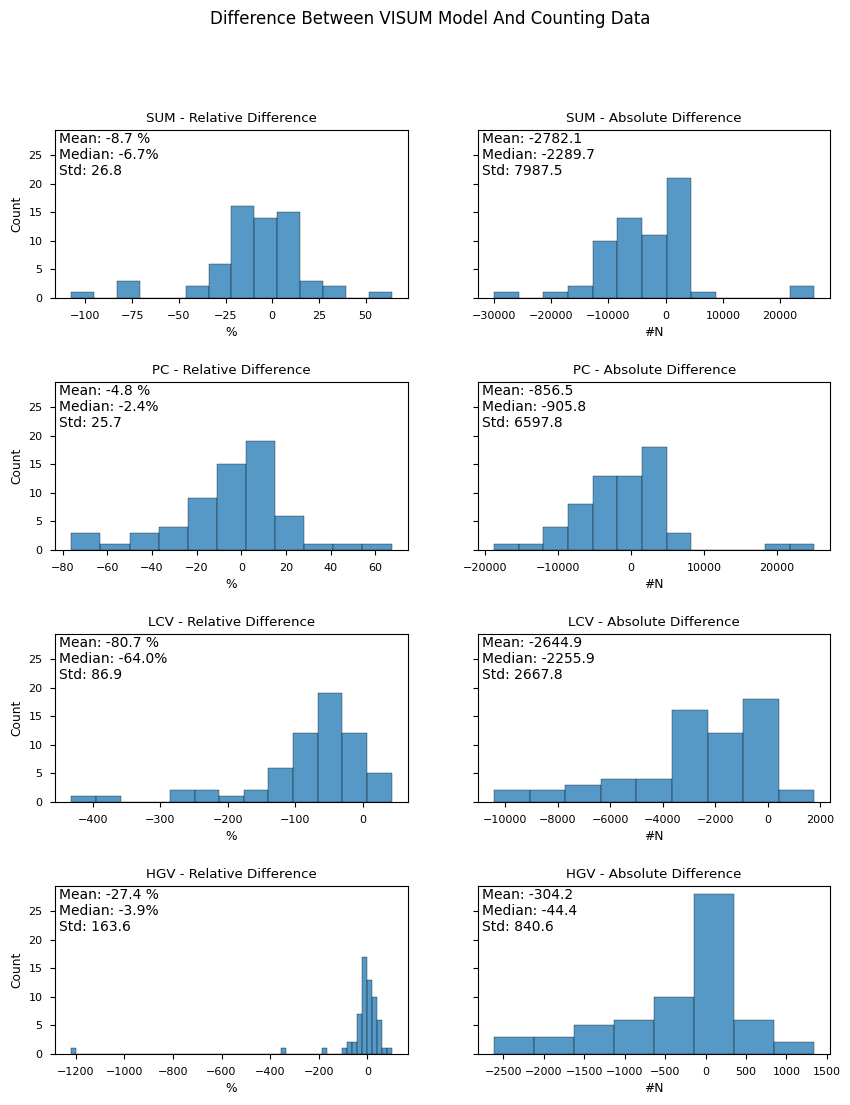

In [8]:
fig, ax  = plt.subplots(4,2, figsize = (10,12), squeeze=False, sharey=True)

data = combined
i = 0
for vc in ['SUM', 'PC', 'LCV', 'HGV']:
    
    data_col1 = data[f'{vc}_diff']
    data_col2 = data[f'{vc}_diff_r']
    
    sns.histplot(ax = ax[i, 0], data=data_col2)
    sns.histplot(ax = ax[i, 1], data=data_col1)
    ax[i, 0].set_title(f'{vc} - Relative Difference')
    ax[i, 1].set_title(f'{vc} - Absolute Difference')
    ax[i, 1].set_xlabel('#N')
    ax[i, 0].set_xlabel('%')
    
    text = f'Mean: {data_col2.mean():.1f} %\nMedian: {data_col2.median():.1f}%\nStd: {data_col2.std():.1f}'
    ax[i,0].text(.01, .99, text, ha='left', va='top', transform=ax[i,0].transAxes)
    
    text = f'Mean: {data_col1.mean():.1f}\nMedian: {data_col1.median():.1f}\nStd: {data_col1.std():.1f}'
    ax[i,1].text(.01, .99, text, ha='left', va='top', transform=ax[i,1].transAxes)
    
    i+=1
    
fig.suptitle('Difference Between VISUM Model And Counting Data')
plt.subplots_adjust(hspace=0.5)

In [9]:
colors = dict(zip(combined['road_type'].unique(), sns.color_palette('colorblind')))

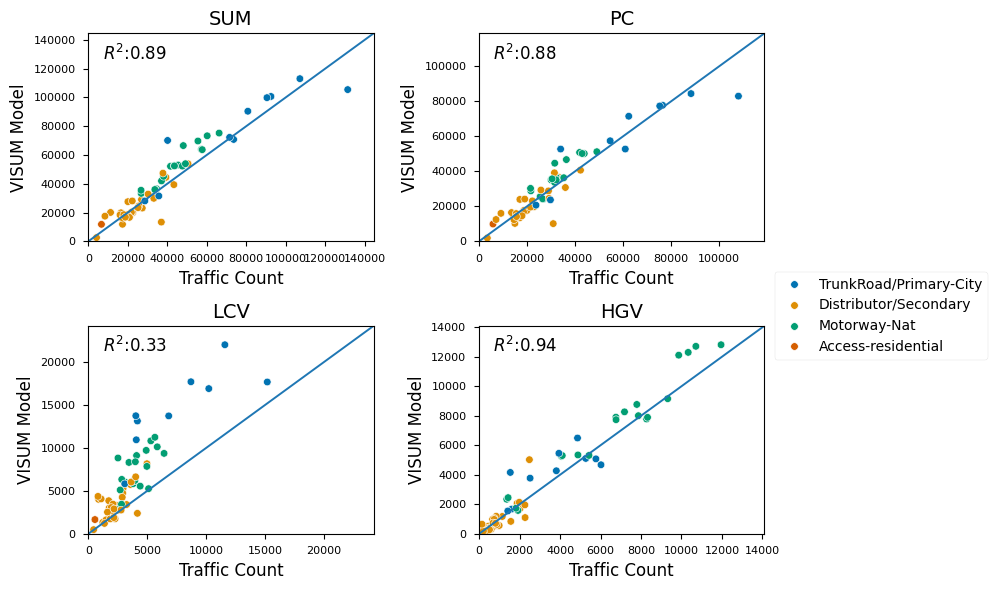

In [10]:
fig, ax  = plt.subplots(2,2, figsize = (8,6), tight_layout=True, squeeze=False)

data = combined
col = 0 
row = 0



for vc in ['SUM', 'PC', 'LCV', 'HGV']:
    
    data_x = data[vc]
    data_y = data[f'dtv_{vc}']
    
    sns.scatterplot(ax = ax[row, col], x=data_x, y=data_y, hue=combined['road_type'], palette=colors, s =30)
    ax[row, col].axline([0,0],[1,1])
    ax[row, col].get_legend().remove()
    
    ax[row, col].set_ylabel('VISUM Model', fontsize = 12)
    ax[row, col].set_xlabel('Traffic Count', fontsize = 12)
    ax[row, col].set_title(f'{vc}', fontsize = 14)
    
    ax[row,col].set_xlim(0,max(pd.concat([data_x, data_y]))*1.1)
    ax[row,col].set_ylim(0,max(pd.concat([data_x, data_y]))*1.1)
    
    r2 = r2_score(data_y, data_x)
    
    text = f'$R^2$:{r2:.2f}'
    ax[row,col].text(.05, .95, text, ha='left', va='top',
                     transform=ax[row,col].transAxes, fontsize=12)
    
    col+=1
    if col >= 2:
        col=0
        row +=1
        
plt.subplots_adjust(wspace=0.3)
plt.subplots_adjust(hspace=0.3)
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.25, 0.55), fontsize = 10)
#fig.suptitle('VISUM Fit Statistics')

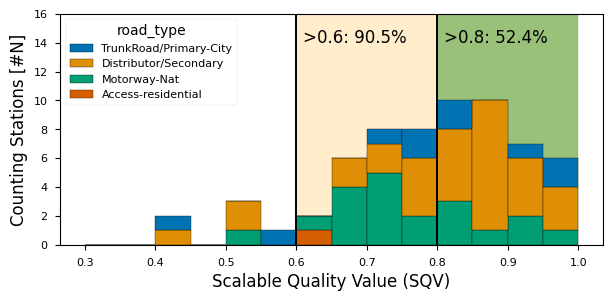

In [14]:
fig = plt.figure(figsize=(7,3))

plt.axvspan(0.6, 1, color = 'orange', zorder = 0, alpha = 0.2)
plt.axvspan(0.8, 1, color = 'green', zorder = 0, alpha = 0.4)
plt.axvline(0.8, c = 'black')
plt.axvline(0.6, c = 'black')
plt.ylim(0,16)

sns.histplot(data=combined, x = 'sqv_SUM', bins = 14, 
             binrange=(0.3,1), hue='road_type', palette = colors, multiple='stack', 
             alpha = 1, legend=True)

plt.text(0.61, 14, f'>0.6: {((len(combined[combined["sqv_SUM"] >= 0.6])/len(combined))*100):.1f}%', fontsize = 12)
plt.text(0.81, 14, f'>0.8: {((len(combined[combined["sqv_SUM"] > 0.8])/len(combined))*100):.1f}%', fontsize = 12)

plt.xlabel('Scalable Quality Value (SQV)', fontsize = 12)
plt.ylabel('Counting Stations [#N]', fontsize = 12)

plt.show(fig)